# PSF Extractor
---

#### Overview
1. Initialize parameters
2. Create stack
3. Find features
4. Filter out overlapping features
5. Mass-based filtering
6. Extract PSFs
7. Filter out strange PSFs
8. Localize PSFs
9. Characterize PSF

#### Libraries

In [1]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### Log settings

In [2]:
import logging
logging.getLogger().setLevel(logging.INFO)

## 1) Initialize parameters
---

Expected feature diameters in $x$, $y$, and optionally $z$ are needed for initial feature detection with `trackpy.locate`. These can either be provided or estimated from known optical parameters such as the numerical aperture, emission wavelength, and pixel size.

In [3]:
# Set pixel sizes [nm/px]
psx = 108
psy = psx
psz = 300

# Set optical parameters:
NA = 0.95  # numerical aperture
lambda_em = 520  # emission wavelength

# Set expected feature diameters [nm]
dx_nm = lambda_em / NA 
dy_nm = dx_nm
dz_nm = 3*dx_nm

# Convert expected feature diameters [nm --> px]
# and round up to nearest odd integer
dx = dx_nm / psx
dy = dy_nm / psy
dz = dz_nm / psz

# Round diameters up to nearest odd integer (as per `trackpy` instructions)
dx, dy, dz = np.ceil([dx, dy, dz]).astype(int) // 2 * 2 + 1

# Output
out = f"""\
Optical settings
----------------
NA.............. {NA:.2f}
Wavelength...... {lambda_em:.0f} nm
Pixelsize x..... {psx:.1f} nm/px
Pixelsize y..... {psy:.1f} nm/px
Pixelsize z..... {psz:.1f} nm/px
Diameter x...... {dx:.0f} px ({dx_nm:.1f} nm)
Diameter y...... {dy:.0f} px ({dy_nm:.1f} nm)
Diameter z...... {dz:.0f} px ({dz_nm:.1f} nm)
"""
print(out)

Optical settings
----------------
NA.............. 0.95
Wavelength...... 520 nm
Pixelsize x..... 108.0 nm/px
Pixelsize y..... 108.0 nm/px
Pixelsize z..... 300.0 nm/px
Diameter x...... 7 px (547.4 nm)
Diameter y...... 7 px (547.4 nm)
Diameter z...... 7 px (1642.1 nm)



#### Spicy colormap

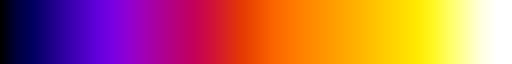

In [4]:
from psf_extractor.util import get_Daans_special_cmap
fire = get_Daans_special_cmap()
fire

In [5]:
import trackpy
from psf_extractor import load_stack, plot_mip

## 2) Create stack
---

In [6]:
# Set directory of image stack
file_pattern = '../data/sample2_zstack_tif_sequence/'
# Load image stack
stack = load_stack(file_pattern)

INFO:root:Creating stack from directory.


  0%|          | 0/34 [00:00<?, ?it/s]

INFO:root:(34, 2048, 2048) image stack created succesfully.


## 3) Find features
---
The first step in the workflow is to detect features (e.g. fluorescent beads) within a 3D image stack. Features are found using `trackpy.locate`, which takes the image stack and expected feature diameters as input. No constraints are provided to `trackpy.locate` such that it returns all possible features on the scale of the expected feature dimensions. We then go through a series of filtering steps to end up with a feature set that ought to be single PSF localizations.

#### Maximum intensity projection in `z`

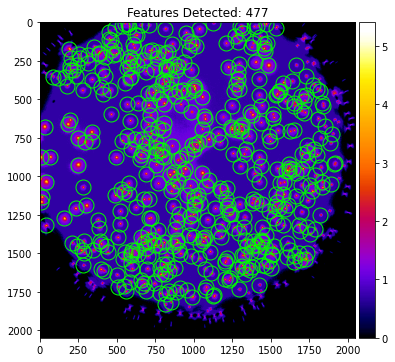

In [7]:
# Get MIP
mip = np.max(stack, axis=0)

# Locate features
features = trackpy.locate(mip, diameter=[dy, dx]).reset_index(drop=True)

# Plot MIP
plot_mip(mip, features=features)

## 4) Filter out overlapping features
---

Overlapping PSFs must be removed so that they do not distort the PSF characterization. To remove them, a virtual bounding box is created around each feature and checked for overlap against every other feature's bounding box.

In [9]:
from psf_extractor import detect_overlapping_features, plot_overlapping_features

  0%|          | 0/25 [00:00<?, ?it/s]

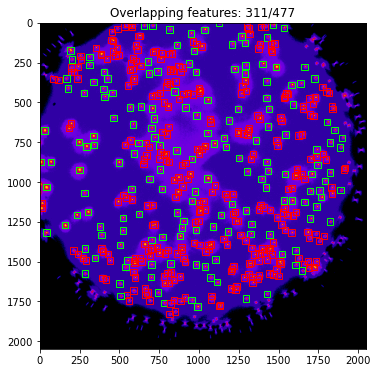

In [10]:
# Set dimensions of bounding box based on expected feature diameter
wx = 8 * dx_nm/psx  # px
wy = 8 * dy_nm/psy  # px

# Detect overlapping features
overlapping = detect_overlapping_features(features, wx=wx, wy=wy)
plot_overlapping_features(mip, features, overlapping, wx, wy)

In [13]:
# Add overlap 
features['overlapping'] = features.index.isin(overlapping)

# Output
out = f"""\
Initial features............ {len(features):.0f}
Overlapping features........ {len(features.loc[features['overlapping'] == True]):.0f}
Remaining features.......... {len(features.loc[features['overlapping'] == False]):.0f}
Random sample of features...
"""
print(out)
features.loc[features['overlapping'] == False].sample(5)

Initial features............ 477
Overlapping features........ 311
Remaining features.......... 166
Random sample of features...



,y,x,mass,size,ecc,signal,raw_mass,ep,overlapping
339,1325.269737,1323.916118,0.841201,1.628791,0.057044,0.078863,4.013453,0.010814,False
237,923.248104,248.286385,3.831063,1.810247,0.180644,0.272560,17.914799,0.002291,False
265,1044.988304,767.610526,1.182939,1.605182,0.094091,0.114835,5.121076,0.008341,False
259,1033.228228,41.957357,2.303619,1.905421,0.258294,0.142506,13.260089,0.003112,False
190,750.622375,246.937848,3.227833,1.645891,0.046685,0.289163,13.681614,0.003014,False


## 5) Mass-based filtering
---

The mass is the "integrated brightness" of a feature. It is important to choose reasonable lower and upper bounds to filter out spurious features (salt) smaller than the PSF and clusters larger than the PSF. It's difficult to know these bounds _a priori_, as the appropriate bounds will vary from dataset to dataset. So it is useful to sample a logarithmic range of candidate bounds and choose proper minimum and maximum masses based on visual inspection.

In [14]:
from ipywidgets import interact, fixed, FloatLogSlider
from psf_extractor import get_min_masses, get_max_masses, plot_mass_range_interactive

#### Choose minimum mass

In [15]:
# Choose minimum mass range
min_masses = get_min_masses(mip, dx=dx, n=35, b=20)

# Interactive plot
widget = interact(plot_mass_range_interactive,
                  mip=fixed(mip),
                  mass=FloatLogSlider(value=np.median(min_masses),
                                      min=np.log10(min_masses.min()),
                                      max=np.log10(min_masses.max())),
                  features=fixed(features.loc[features['overlapping'] == False]),
                  filtering=fixed('min'));

interactive(children=(FloatLogSlider(value=7.593356329610143, description='mass', max=2.1814637759386293, min=…

In [16]:
# Set minimum mass
min_mass = widget.widget.children[0].value

#### Choose maximum mass

In [17]:
# Get candidate maximum masses
max_masses = get_max_masses(min_mass, n=31, b=20)

widget = interact(plot_mass_range_interactive,
                  mip=fixed(mip),
                  mass=FloatLogSlider(value=np.median(max_masses),
                                      min=np.log10(max_masses.min()),
                                      max=np.log10(max_masses.max())),
                  features=fixed(features.loc[(features['overlapping'] == False) &\
                                              (features['raw_mass'] > min_mass)]),
                  filtering=fixed('max'));

interactive(children=(FloatLogSlider(value=13.48698883038979, description='mass', max=1.780429995663981, min=0…

In [21]:
# Set minimum mass
max_mass = widget.widget.children[0].value

N_a = len(features.loc[(features['overlapping'] == False) &\
                       (features['raw_mass'] < min_mass)])
N_b = len(features.loc[(features['overlapping'] == False) &\
                       (features['raw_mass'] > max_mass)])
N_c = len(features.loc[(features['overlapping'] == False) &\
                       (features['raw_mass'] > min_mass) &\
                       (features['raw_mass'] < max_mass)])

# Output
out = f"""\
Minimum mass.................. {min_mass:.2f}
Maximum mass.................. {max_mass:.2f}
Too dim (min filtered)........ {N_a:.0f}
Too bright (max filtered)..... {N_b:.0f}
Remaining features............ {N_c:.0f}
Random sample of features.....
"""
print(out)
features.loc[(features['overlapping'] == False) &\
             (features['raw_mass'] > min_mass) &\
             (features['raw_mass'] < max_mass)].sample(5)

Minimum mass.................. 3.02
Maximum mass.................. 15.11
Too dim (min filtered)........ 8
Too bright (max filtered)..... 2
Remaining features............ 156
Random sample of features.....



,y,x,mass,size,ecc,signal,raw_mass,ep,overlapping
316,1225.307270,521.308642,1.008611,1.612281,0.051769,0.098232,4.466368,0.009645,False
110,416.112000,399.001333,1.037666,1.497108,0.100822,0.112068,4.130045,0.010487,False
456,1694.775895,743.293785,0.734668,1.694680,0.088744,0.063644,3.502242,0.012528,False
101,382.178042,1637.005935,0.932516,1.539779,0.138849,0.095465,4.035874,0.010750,False
22,91.890756,1428.171429,0.823215,1.599895,0.134665,0.078863,3.609865,0.012124,False


## 6) Extract PSFs
---

All of the filtered PSFs must be extracted before they can be aligned and averaged. We already have the rough coordinates of each PSF from filtering the features detected by `trackpy.locate`. So we simply define a subvolume containing the PSF and extract.

In [22]:
from psf_extractor import extract_psfs, plot_psfs

#### Define subvolume and extract PSFs

In [24]:
# Set dimensions of PSF subvolume based on expected feature diameter
wx = 5 * dx_nm/psx   # px
wy = 5 * dy_nm/psy   # px
wz = 15 * dz_nm/psz  # px
shape_psf = (wz, wy, wx)

# Feature set for extracting PSFs
df = features.loc[(features['overlapping'] == False) &\
                  (features['raw_mass'] > min_mass) &\
                  (features['raw_mass'] < max_mass)]

# Extract PSFs
psfs, edge_features = extract_psfs(stack, features=df, shape=shape_psf, return_features=True)

#### Plot the maximum intensity projection of each extracted PSF

  0%|          | 0/153 [00:00<?, ?it/s]

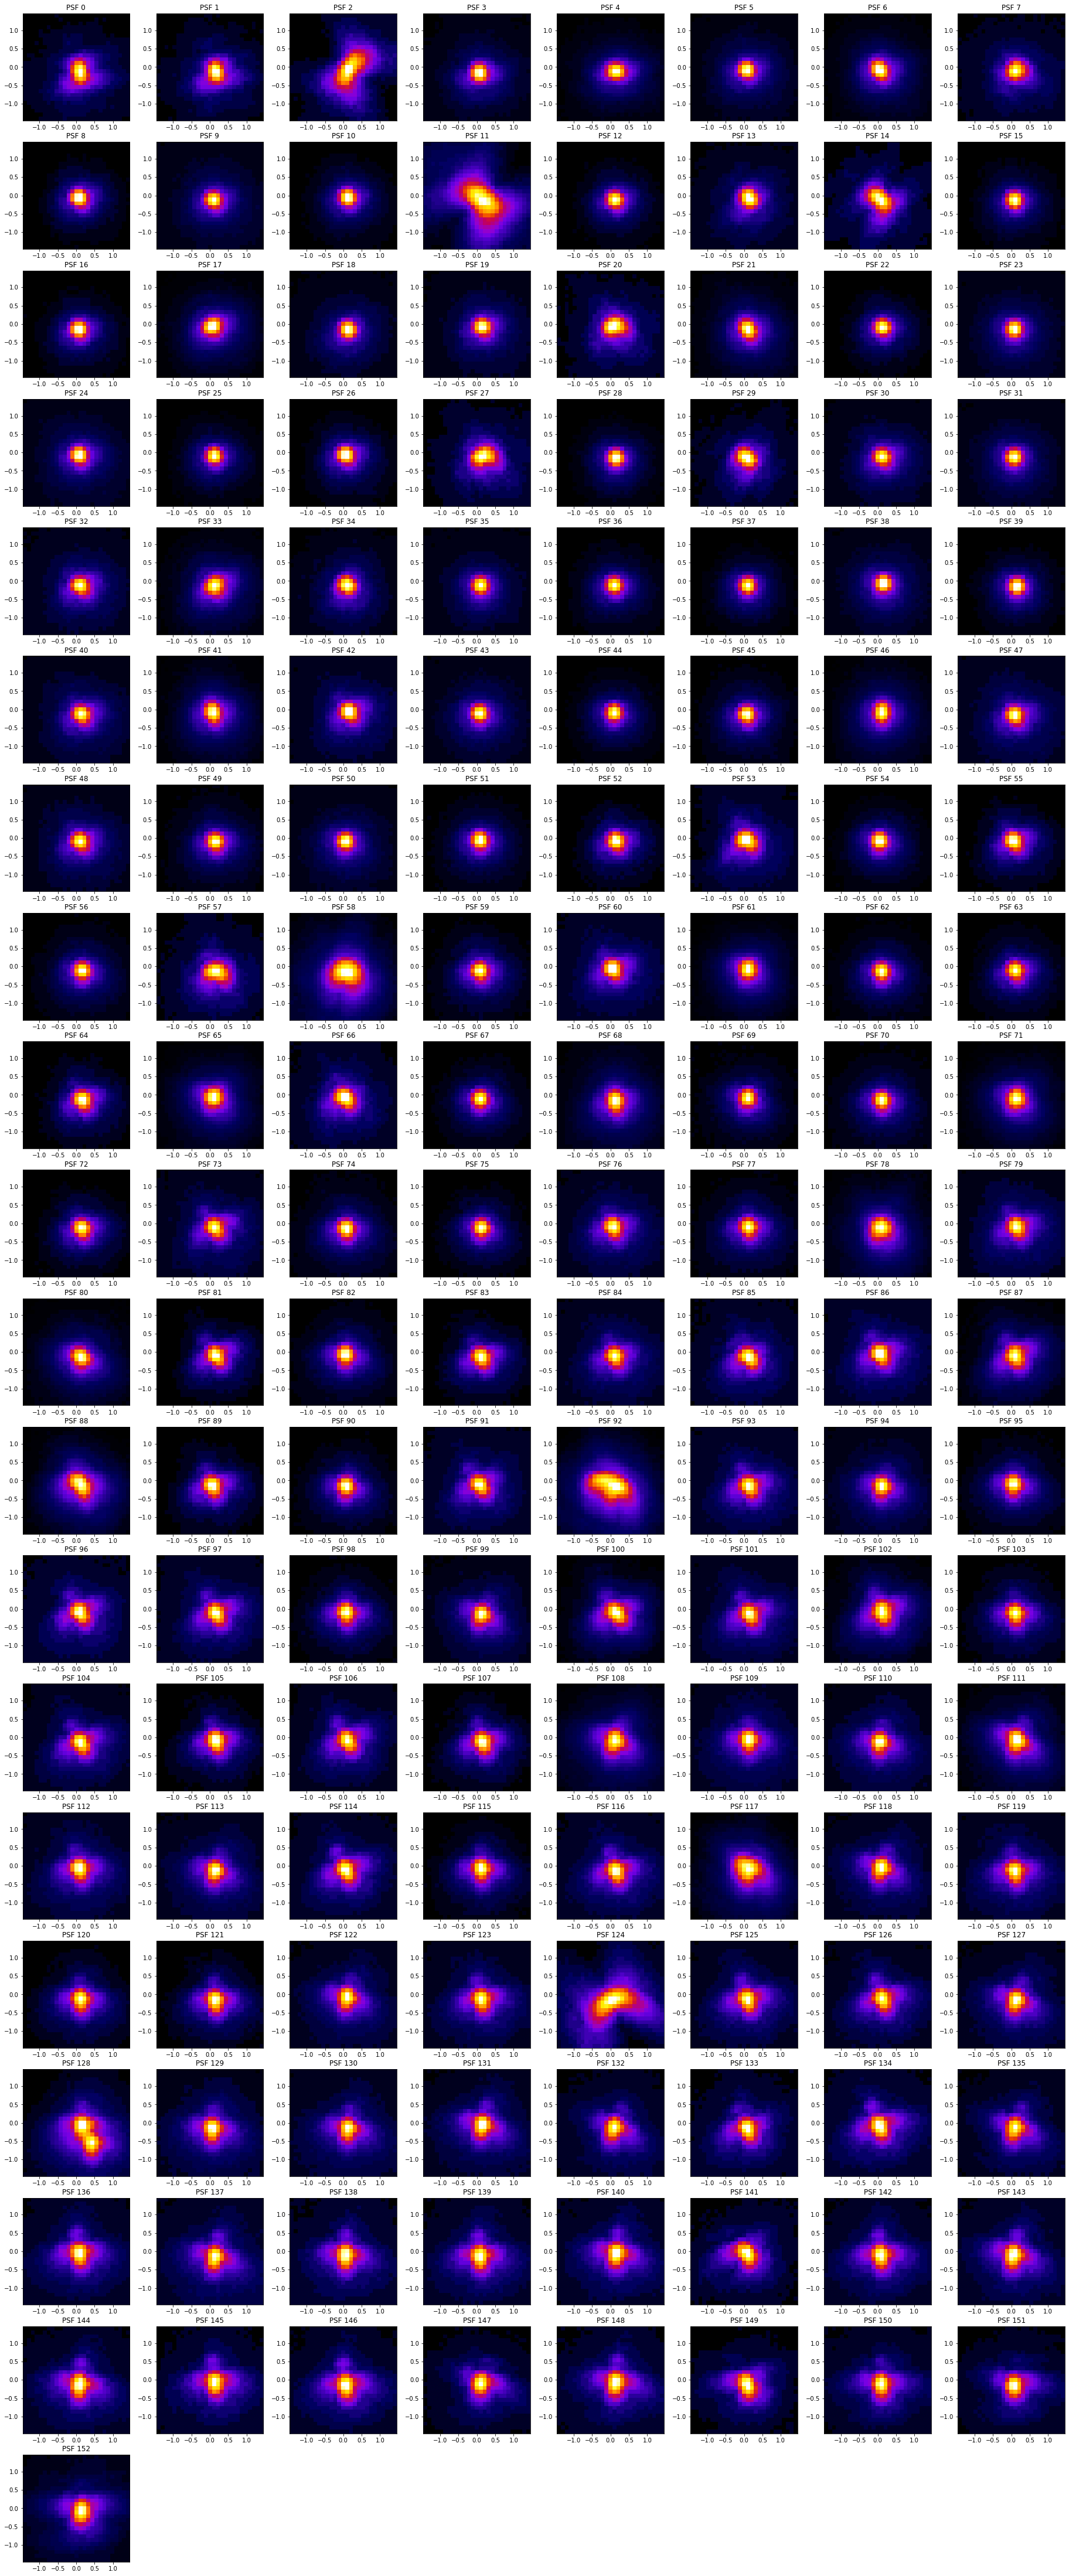

In [25]:
# Plot PSF MIPs
plot_psfs(psfs, psx, psy)

In [ ]:
# Update feature set
features = df.reset_index(drop=True)

# Output
out = f"""\
Initial features............ {N_features:.0f}
Edge features............... {N_features - len(psfs):.0f}
Remaining features.......... {len(features):.0f}
Random sample of features...
"""
print(out)
features.sample(5)

## 7) Filter out strange PSFs
---

Use the Pearson correlation coefficient to filter out oultier PSFs. Each PSF is compared to every other PSF. Outlier criteria is based on a PSF having a PCC that frequently falls below 0.9. Why 0.9? Would you be satisfied with less than an "A"? Didn't think so...

Why isn't once enough? Because it takes 2 PSFs to generate a wild PCC value. One of these PSFs may be totally fine, but the only way to tell a typical PSF from an outlier is by checking the number of occurences each PSF falls in the outlier range.

How many times is frequently? A bit arbitrary, but 3× the average number of occurences seems to work empirically.

In [ ]:
from psf_extractor import detect_outlier_psfs, plot_pcc_distribution

In [ ]:
# Set minimum PCC threshold
pcc_min = 0.9

# Detect outlier PCCs
outliers, pccs = detect_outlier_psfs(psfs, pcc_min=pcc_min, return_pccs=True)

#### Plot distribution of Pearson correlation coefficients

In [ ]:
plot_pcc_distribution(pccs, pcc_min=pcc_min, bins=pccs.size//2)

In [ ]:
# Update feature set
features = features.drop(index=outliers)

# Output
out = f"""\
Initial features............ {len(psfs):.0f}
Outlier features............ {outliers.size:.0f}
Remaining features.......... {len(features):.0f}
Random sample of features...
"""
print(out)
features.sample(5)

## 8) Localize PSFs
---

The individual PSF positions must be localized with subpixel accuracy in $x$, $y$, and $z$. First, we fit a 2D Gaussian to each PSF in the maximum intensity projection to get the $x$, $y$ position. Then we fit a 1D Gaussian to the line profile through the center of the PSF to get the $z$ position.

* 2D Gaussian fit for $x$, $y$ localization 
* 1D Gaussian fit for $z$ localization
  * Might it be better to sum/integrate in x, y?

In [ ]:
from psf_extractor import localize_psfs, plot_psf_localizations

In [ ]:
# Re-extract PSFs based on updated feature set
psfs = extract_psfs(stack, features=features, shape=shape_psf)

# Localize PSFs
df_locations = localize_psfs(psfs, integrate=False)
df_locations.head()

#### Plot localization data

In [ ]:
plot_psf_localizations(df_locations)

## 9) Characterize PSF
---

Upsample and align PSFs

#### Upsample and align PSFs

In [ ]:
from psf_extractor import align_psfs, crop_psf, plot_psf

In [ ]:
# Set upsample factor
usf = 5

# Align PSFs
psf_sum = align_psfs(psfs, df_locations, upsample_factor=usf)

#### Plot PSF

In [ ]:
from psf_extractor import gaussian_1D, fit_gaussian_1D

In [ ]:
# Crop PSF
psf_sum = crop_psf(psf_sum, psx, psy, psz)

# Plot PSF
plot_psf(psf_sum, psx/usf, psy/usf, psz/usf)